# Victoria Bike Path Analysis

Welcome to my bike path analysis, a side project that I am using to teach myself python and data science. 
 
From this project, I would like to:
- see how ETL works on python and if I prefer it to a GUI system, like PowerQuery
- see if bike rideship is seasonal
- see what % of riders miss consecutive checkpoints and where these are?
- add the Strategic Cycling Corridor dataset to the mix
- see if I can work out some data science techniques - such as Machine Learning and AI

In [1]:
#Importing Libaries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import glob
import re
import io
import zipfile
from itertools import islice

In [2]:
#Setup URL Files
#Header Data
VicRoadsHeader_URL = 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/VicRoads_Bike_Site_Number_Listing.csv'

#Yearly Data
Bicycle_Vol = {'Bicycle_Vol_2023_URL' : 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_Speed_2023.zip',
               'Bicycle_Vol_2022_URL' : 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_Speed_2022.zip',
               'Bicycle_Vol_2021_URL' : 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_Speed_2021.zip',
               'Bicycle_Vol_2020_URL' : 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_Speed_2020.zip',
               'Bicycle_Vol_2019_URL' : 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_Speed_2019.zip',
               'Bicycle_Vol_2018_URL' : 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_Speed_2018.zip',
               'Bicycle_Vol_2017_URL' : 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_Speed_2017.zip',
               'Bicycle_Vol_2016_URL' : 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_Speed_2016.zip',
               'Bicycle_Vol_2015_URL' : 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_speed_2015.zip'}

In [3]:
#Create folders for storing data

#ensure home directory is the home director of this program
os.chdir(os.getcwd())
home = os.getcwd()
print("Home file = " + home)

#create folder called data in the home dir
datafolder = os.path.join(home,'data') 
if os.path.exists(datafolder) == False:
    os.mkdir(datafolder)
    print("Made directory = " + datafolder)

#create folder called zip in the data dir
zipfolder = os.path.join(datafolder, 'zip') 
if os.path.exists(zipfolder) == False:
    os.mkdir(zipfolder)
    print("Made directory = " + zipfolder)

#create folder called extracted in the data dir
extractedFolder = os.path.join(datafolder, 'extracted') 
if os.path.exists(extractedFolder) == False:
    os.mkdir(extractedFolder)
    print("Made directory = " + extractedFolder)

Home file = c:\Users\Phil\Documents\Projects\BikePath
Made directory = c:\Users\Phil\Documents\Projects\BikePath\data
Made directory = c:\Users\Phil\Documents\Projects\BikePath\data\zip
Made directory = c:\Users\Phil\Documents\Projects\BikePath\data\extracted


In [4]:
#download header and write it to header excel file
Header = requests.get(VicRoadsHeader_URL)
savePath = os.path.join(datafolder, 'VicRoadsHeader.csv')

with open(savePath,'wb') as output:
        output.write(Header.content)
        print("File Saved = " + savePath)

File Saved = c:\Users\Phil\Documents\Projects\BikePath\data\VicRoadsHeader.csv


In [5]:
#read the first lines of VicRoads Header File
print(savePath)
Headerdf = pd.read_csv(savePath)
print(Headerdf.head())

c:\Users\Phil\Documents\Projects\BikePath\data\VicRoadsHeader.csv
   SITE_XN_ROUTE  LOC_LEG  STRT_LAT  STRT_LONG                       GPS  \
0           6411    59437 -37.77231  144.99042  [-37.772347 +144.990631]   
1           6411    59438 -37.77235  144.99077  [-37.772347 +144.990631]   
2           6415    59485 -37.82713  144.98511  [-37.827009 +144.984261]   
3           6415    59486 -37.82714  144.98513  [-37.827009 +144.984261]   
4           6419    59458 -37.75829  144.98039  [-37.758216 +144.980308]   

   SITE_NAME                                           TFM_DESC BEARING_DESC  \
0  D208X6411  (BIKE PATH) ST. GEORGES RD N BD 28M S OF SUMNE...  NORTH BOUND   
1  D208X6411  (BIKE PATH) ST. GEORGES RD S BD 28M S OF SUMNE...  SOUTH BOUND   
2  D208X6415  (BIKE PATH) NORTH BANK E BD 75M W OF MORELL BR...   EAST BOUND   
3  D208X6415  (BIKE PATH) NORTH BANK W BD 75M W OF MORELL BR...   WEST BOUND   
4  D208X6419  (BIKE PATH) MERRI CREEK TRAIL N BD S OF MORELA...  NORTH BOUND 

---
***Note from Author***

The header file changed from a xlsx to a CSV file, which caused an error with my code. 

I've noted that the header file contains the GPS cood and address titles for the datasets.

Here is a cheatsheet for the keys to join the header data to the file datasets:
- Header.SITE_NAME = file.TIS_DATA_REQUEST + "X" + file.SITE_XN_ROUTE
- Header.TFM_ID = file.LOC_LEG - this shit is oldddd!!! Looks to now match keys.  Use Loc_leg for both
---

In [6]:
#Download the zip files

Bicycle_Vol_Zip_Files = [] #create an empty list to idenitfy the list zips once created.

#subset the list to just one zip file for testing purposes;  There is 8 in total above up, from 2015 to 2022.
#!!! [Testing routine - replace n_items with Bicycle_Vol.items(); review additional comment, below, in dictionary creation - key,value line - section]
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

n_items = take(1, Bicycle_Vol.items()) 
#[end of testing routine. instructions above to remove testing]

print("Dictionary file: [Name, Zip File] = ", n_items) 

#download zips from website and label using as subset of the dictionary for the URLs  
for key, url in n_items: #replace n_items with Bicycle_Vol.items() when testing is resolved
    
    from urllib.parse import urlparse
    saveFile = os.path.basename(urlparse(url).path) #take only the filename from the URL. e.g. Bicycle_Volume_speed_2015.zip
    savePath = os.path.join(zipfolder, saveFile )  
    
    Bicycle_Vol_Zip_Files.append(savePath) #Populate the empty list with filepaths of the zips.
    
    if os.path.exists(savePath) == False: #Idea: add a search to the string of the filename for year(today()) to re-download if this year.
        resp = requests.get(url) #download the zip file
        with open(savePath,'wb') as output:
            output.write(resp.content)
            print("File Saved = " + savePath)
    else:
        print("Skipping file as already exists: " + savePath)

    

Dictionary file: [Name, Zip File] =  [('Bicycle_Vol_2023_URL', 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Traffic_Measurement/Bicycle_Volume_and_Speed/Bicycle_Volume_Speed_2023.zip')]
File Saved = c:\Users\Phil\Documents\Projects\BikePath\data\zip\Bicycle_Volume_Speed_2023.zip


In [7]:
#Nested Zip Function V2
#https://stackoverflow.com/questions/36285502/how-to-extract-zip-file-recursively
#credit to Forge - 29/03/2016

def extract_nested_zip_v2(filename, DestinationPath):
    z = zipfile.ZipFile(filename)
    for f in z.namelist():
        # get directory name from file
        dirName = os.path.join(DestinationPath, os.path.splitext(f)[0])
        
        #this line of code is drawining an error.  Suspect it is because python uses linx / and zip is using \ for their internal folder strcutre.
        # create new directory
        if os.path.exists(dirName) == False:
            os.makedirs(dirName) #using makedirs rather than mkdir because zips paths include subfolders
        # read inner zip file into bytes buffer 
        content = io.BytesIO(z.read(f))
        zip_file = zipfile.ZipFile(content)
        
        for i in zip_file.namelist():
            zip_file.extract(i, dirName) 
           
        

In [8]:
#extract all data into the data folder.  Delete all zips and keep going until there are no more zips.
for File in Bicycle_Vol_Zip_Files:
    #print("Extracting Zip: " + File + " into " + extractedFolder)
    try:
        extract_nested_zip_v2(File, extractedFolder)
    except:
        print("Error! - Extracting Zip: " + File + " into " + extractedFolder)

In [9]:
#example of bad filename = "IND_D5555_X32021.csv.20150523" 
#example of good filename = "IND_D5555_X32021_20150523.csv"

#clean up any CSV files that don't have an extension and make it a CSV file
for path, dirs, files in os.walk(extractedFolder):
    for file in files:
        
        filename, file_ext = os.path.splitext(file) #filename = #IND_D5555_X32021.csv; #file_ext = "20150523"
        if re.search('\d', file_ext):  #check the extension for numbers to identify bad data files with numbers as extensions;  These need the numbers removed and then a CSV readded.  This should be the filter to stop good filenames from coming through this routine.
            
            Original_Filename = os.path.join(
                                            path, file) 
            """
            print("filename = " + filename) 
            print("file_ext = " + file_ext[1:])
            print("corrected filename = " + filename.replace(".csv", "_" + file_ext[1:]))
            print(path)
            """

            Corrected_Filename = os.path.join(
                                            path, #c:\Users\Study\Documents\Projects\Bike Paths\BikePath\data\extracted\Bicycle_Volume_speed_2015\IND_D5555_X32021.csv (2015)\
                                             
                                            filename.replace(".csv", "_" + file_ext[1:]) #replace .csv with "_" and add "20150523"
                                            + ".csv") #add csv to return the filename correctly.
            
            #print("Original: " + Original_Filename + "\n Corrected: " + Corrected_Filename)
            
            try:
                os.replace(Original_Filename, Corrected_Filename)  #remove the .csv in the filename and put the extension in it's place.  The date was put in the wrong spot.
            
            except:
                  print("Error! - Couldn't rename: " + Original_Filename + " to /n" + Corrected_Filename)

In [12]:
#join all CSV's into a dataframe; 
# 1 Year file takes  > 5 min to load due to date parsing of the Date & Time Columns. Or it takes < 1 min if only parsing date. 

csv_files = glob.glob(extractedFolder + "/**/*.csv", recursive=True)

df_list = (pd.read_csv(file, index_col=None, header=0, parse_dates=['DATE'], dayfirst=True) for file in csv_files) #creates a list of dataframes

big_df = pd.concat(df_list, axis=0, ignore_index=True) #appends the dataframe list



C:\Users\Phil\AppData\Local\Temp\ipykernel_10200\2261031834.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat(df_list, axis=0, ignore_index=True) #appends the dataframe list


In [52]:
big_df.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145183 entries, 0 to 5145182
Data columns (total 17 columns):
 #   Column            Dtype         
---  ------            -----         
 0   DATA_TYPE         object        
 1   TIS_DATA_REQUEST  object        
 2   SITE_XN_ROUTE     object        
 3   LOC_LEG           object        
 4   DATE              datetime64[ns]
 5   TIME              object        
 6   CLASS             object        
 7   LANE              object        
 8   SPEED             float64       
 9   WHEELBASE         float64       
 10  HEADWAY           float64       
 11  GAP               float64       
 12  AXLE              object        
 13  AXLE_GROUPING     float64       
 14  RHO               float64       
 15  VEHICLE           object        
 16  DIRECTION         object        
dtypes: datetime64[ns](1), float64(6), object(10)
memory usage: 2.5 GB


In [13]:
for column in big_df:
    if big_df[column].dtype == 'float32':
        big_df[column]=pd.to_numeric(big_df[column], downcast='float')
    if big_df[column].dtype=='int64':
        big_df[column]=pd.to_numeric(big_df[column], downcast='integer')

big_df.convert_dtypes().dtypes

DATA_TYPE           string[python]
TIS_DATA_REQUEST             Int64
SITE_XN_ROUTE                Int64
LOC_LEG                      Int64
DATE                datetime64[ns]
TIME                string[python]
CLASS                        Int64
LANE                         Int64
SPEED                      Float64
WHEELBASE                  Float64
HEADWAY                    Float64
GAP                        Float64
AXLE                         Int64
AXLE_GROUPING                Int64
RHO                        Float64
VEHICLE             string[python]
DIRECTION           string[python]
dtype: object

In [54]:
big_df.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145183 entries, 0 to 5145182
Data columns (total 17 columns):
 #   Column            Dtype         
---  ------            -----         
 0   DATA_TYPE         object        
 1   TIS_DATA_REQUEST  object        
 2   SITE_XN_ROUTE     object        
 3   LOC_LEG           object        
 4   DATE              datetime64[ns]
 5   TIME              object        
 6   CLASS             object        
 7   LANE              object        
 8   SPEED             float64       
 9   WHEELBASE         float64       
 10  HEADWAY           float64       
 11  GAP               float64       
 12  AXLE              object        
 13  AXLE_GROUPING     float64       
 14  RHO               float64       
 15  VEHICLE           object        
 16  DIRECTION         object        
dtypes: datetime64[ns](1), float64(6), object(10)
memory usage: 2.5 GB


In [55]:
print(big_df.shape) #excludes index col.

(5145183, 17)


In [56]:
print(big_df.head(10))

  DATA_TYPE TIS_DATA_REQUEST SITE_XN_ROUTE LOC_LEG       DATE      TIME CLASS  \
0       IND              208         10223   59444 2021-12-27  04:48:42    15   
1       IND              208         10223   59443 2021-12-27  05:25:27    15   
2       IND              208         10223   59443 2021-12-27  05:40:44    15   
3       IND              208         10223   59443 2021-12-27  05:40:45    15   
4       IND              208         10223   59443 2021-12-27  05:40:47    15   
5       IND              208         10223   59443 2021-12-27  05:48:52    15   
6       IND              208         10223   59444 2021-12-27  05:49:46    15   
7       IND              208         10223   59443 2021-12-27  05:54:12    15   
8       IND              208         10223   59443 2021-12-27  05:58:59    15   
9       IND              208         10223   59443 2021-12-27  06:06:05    15   

  LANE  SPEED  WHEELBASE  HEADWAY     GAP AXLE  AXLE_GROUPING  RHO VEHICLE  \
0    1   16.0        1.0    29

In [17]:
from pathlib import Path
export_csv_filepath = Path('data/export/database.csv') 
big_df.to_csv(export_csv_filepath)

In [57]:
big_df.describe(include = [np.number]).apply(lambda s: s.apply(lambda x: format(x, 'g'))) #.apply nested lambdas to suppress sci notation


,SPEED,WHEELBASE,HEADWAY,GAP,AXLE_GROUPING,RHO
count,5.14518e+06,4.8141e+06,4.8141e+06,4.8141e+06,4.8141e+06,5.14518e+06
mean,21.53,1.03052,239.662,241.972,1,0.989077
std,6.36064,0.0849181,1585.67,1815.53,0,0.0706908
min,0.5,0,0,0,1,0
25%,17.4,1,7.3,7.1,1,1
50%,21.3,1,49.8,49.6,1,1
75%,25.4,1.1,155.4,155.2,1,1
max,159.3,6.9,86400,506783,1,1.33


### Comment:
Speed Data looks right.  Maximums, seem a little high.  Outliers?  Try and remove thoes and see what it looks like.

"Headway" =  time between the first axles of two vehicles travelling in the same direction.
"Gap" =  time between the last axle and first axle of two vehicles travelling in the same direction.
"Axle Grouping" = Number of axles
"RHO" = Axle Correlation / Average of Senosr Correlation [0 to 1]


2022 Data (3/07/2022):
1. 5,1m rows of data for all columns; except: 
2. 4.81m rows for Wheelbase/Headway/Gap & Axle Grouping.  

**Question**. I wonder why #2 didn't have as many?

In [58]:
big_df.describe(include = ['O'])

,DATA_TYPE,TIS_DATA_REQUEST,SITE_XN_ROUTE,LOC_LEG,TIME,CLASS,LANE,AXLE,VEHICLE,DIRECTION
count,5145183,5145183,5145183,5145183,5145183,5145183,5145183,5145183,5145183,5145183
unique,1,2,46,90,84230,2,4,1,3,4
top,IND,208,32021,60182,08:18:26,15,1,2,CYCLE,S
freq,5145183,4814097,331086,331086,196,5144976,2444146,5145183,4813890,2259116


In [59]:
big_df['LOC_LEG'].unique()

array([59444, 59443, 20082, 29929, 59482, 59481, 31906, 42173, 24027,
       28656, 59476, 59475, 59709, 59708, 60963, 61168, 61171, 61172,
       61173, 61174, 61177, 61178, 61175, 61176, 62154, 62155, 63748,
       63749, 63750, 63751, 63752, 63753, 63846, 63934, 63935, 64398,
       64397, 59437, 59438, 59485, 59486, 59458, 59459, 59461, 59460,
       59452, 59453, 59455, 59454, 59465, 59464, 59445, 59468, 59451,
       59450, 59484, 59483, 59489, 59490, 59466, 59467, 59487, 59488,
       59447, 59446, 59448, 59449, 59470, 59469, 59462, 59463, 59456,
       59457, 59474, 59473, 23042, 40292, 59478, 59477, 32153, 20272,
       63932, 63933, 70008, 70009, 70011, 70010, 70728, 70727, 60182],
      dtype=object)

In [60]:
big_df['DATE'].describe(datetime_is_numeric=True)

count                          5145183
mean     2022-04-29 20:41:06.476934400
min                2021-12-20 00:00:00
25%                2022-02-22 00:00:00
50%                2022-04-13 00:00:00
75%                2022-06-14 00:00:00
max                2022-12-06 00:00:00
Name: DATE, dtype: object

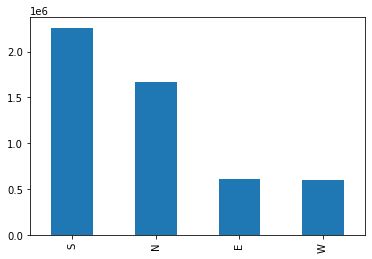

In [61]:
big_df['DIRECTION'].value_counts().plot.bar()

"""
fig, ax = plt.subplots()
ax.plot(speeddf['SPEED'], marker ='o', linestyle='--', color='r')
#ax.plot(big_df['DATE'], big_df['SPEED'])
ax.set_xlabel("YY-MM")
ax.set_ylabel("Speed")
date_form = DateFormatter("%y-%d")
ax.xaxis.set_major_formatter(date_form)
"""
plt.show() 

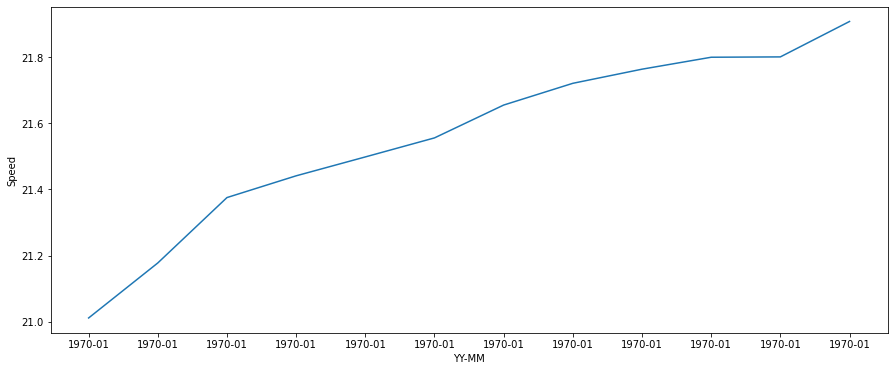

In [62]:
#ax.plot(speeddf['DATE'], speeddf['SPEED'], marker ='o', linestyle='--', color='r')

fig, ax = plt.subplots(figsize=(15,6))

#big_df.groupby(big_df['DATE'].dt.strftime('%B'))['SPEED'].mean().sort_values()

ax.plot(big_df.groupby(big_df['DATE'].dt.strftime('%m'))['SPEED'].mean().sort_values())

ax.set_ylabel("Speed")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlabel("YY-MM")

plt.show() 

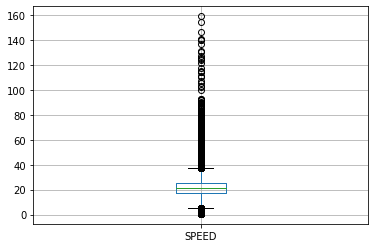

In [63]:
boxplot = big_df.boxplot(column=['SPEED'])  

In [68]:
big_df.merge(Headerdf, left_on='LOC_LEG', right_on='LOC_LEG', how='left', indicator=True)



,DATA_TYPE,TIS_DATA_REQUEST,SITE_XN_ROUTE_x,LOC_LEG,DATE,TIME,CLASS,LANE,SPEED,WHEELBASE,...,STRT_LAT,STRT_LONG,GPS,SITE_NAME,TFM_DESC,BEARING_DESC,DATA_SRC_CD,RGN_SHORT_NM,Comments,_merge
0,IND,208,10223,59444,2021-12-27,04:48:42,15,1,16.0,1.0,...,-37.81146,145.06363,[-37.811591 +145.063684],D208X10223,(BIKE PATH) ANN TRAIL NO:1 SE BD 104M SOUTH OF...,SOUTH EAST BOUND,ACBYC,METRO SOUTH EAST,NaN,both
1,IND,208,10223,59443,2021-12-27,05:25:27,15,0,37.4,1.0,...,-37.81153,145.06365,[-37.811591 +145.063684],D208X10223,(BIKE PATH) ANN TRAIL NO:1 NW BD 104M SOUTH OF...,NORTH WEST BOUND,ACBYC,METRO SOUTH EAST,NaN,both
2,IND,208,10223,59443,2021-12-27,05:40:44,15,0,35.6,1.0,...,-37.81153,145.06365,[-37.811591 +145.063684],D208X10223,(BIKE PATH) ANN TRAIL NO:1 NW BD 104M SOUTH OF...,NORTH WEST BOUND,ACBYC,METRO SOUTH EAST,NaN,both
3,IND,208,10223,59443,2021-12-27,05:40:45,15,0,36.3,1.0,...,-37.81153,145.06365,[-37.811591 +145.063684],D208X10223,(BIKE PATH) ANN TRAIL NO:1 NW BD 104M SOUTH OF...,NORTH WEST BOUND,ACBYC,METRO SOUTH EAST,NaN,both
4,IND,208,10223,59443,2021-12-27,05:40:47,15,0,34.9,1.0,...,-37.81153,145.06365,[-37.811591 +145.063684],D208X10223,(BIKE PATH) ANN TRAIL NO:1 NW BD 104M SOUTH OF...,NORTH WEST BOUND,ACBYC,METRO SOUTH EAST,NaN,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145178,IND,5555,32021,60182,2022-06-30,21:05:18,15,2,18.0,NaN,...,-37.97548,145.01590,[-37.975480 145.01590],D208X32021,(BIKE LANE) BLACK ROCK BEACH ROAD NEAR BLUFF ROAD,SOUTH BOUND,ACBYC,METRO SOUTH EAST,City of Bayside,both
5145179,IND,5555,32021,60182,2022-06-30,21:05:21,15,1,16.0,NaN,...,-37.97548,145.01590,[-37.975480 145.01590],D208X32021,(BIKE LANE) BLACK ROCK BEACH ROAD NEAR BLUFF ROAD,SOUTH BOUND,ACBYC,METRO SOUTH EAST,City of Bayside,both
5145180,IND,5555,32021,60182,2022-06-30,21:05:21,15,1,16.0,NaN,...,-37.97548,145.01590,[-37.975480 145.01590],D208X32021,(BIKE LANE) BLACK ROCK BEACH ROAD NEAR BLUFF ROAD,SOUTH BOUND,ACBYC,METRO SOUTH EAST,City of Bayside,both
5145181,IND,5555,32021,60182,2022-06-30,21:05:21,15,1,16.0,NaN,...,-37.97548,145.01590,[-37.975480 145.01590],D208X32021,(BIKE LANE) BLACK ROCK BEACH ROAD NEAR BLUFF ROAD,SOUTH BOUND,ACBYC,METRO SOUTH EAST,City of Bayside,both


In [67]:
big_df.describe(include = 'all')

C:\Users\Study\AppData\Local\Temp\ipykernel_23336\73833823.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  big_df.describe(include = 'all')


,DATA_TYPE,TIS_DATA_REQUEST,SITE_XN_ROUTE,LOC_LEG,DATE,TIME,CLASS,LANE,SPEED,WHEELBASE,HEADWAY,GAP,AXLE,AXLE_GROUPING,RHO,VEHICLE,DIRECTION
count,5145183,5145183.0,5145183.0,5145183.0,5145183,5145183,5145183.0,5145183.0,5.145183e+06,4.814097e+06,4.814097e+06,4.814097e+06,5145183.0,4814097.0,5.145183e+06,5145183,5145183
unique,1,2.0,46.0,90.0,218,84230,2.0,4.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3,4
top,IND,208.0,32021.0,60182.0,2022-02-05 00:00:00,08:18:26,15.0,1.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,CYCLE,S
freq,5145183,4814097.0,331086.0,331086.0,66288,196,5144976.0,2444146.0,NaN,NaN,NaN,NaN,5145183.0,NaN,NaN,4813890,2259116
first,NaN,NaN,NaN,NaN,2021-12-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2022-12-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.153002e+01,1.030519e+00,2.396624e+02,2.419715e+02,NaN,1.0,9.890766e-01,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.360645e+00,8.491807e-02,1.585670e+03,1.815525e+03,NaN,0.0,7.069077e-02,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,NaN,1.0,0.000000e+00,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.740000e+01,1.000000e+00,7.300000e+00,7.100000e+00,NaN,1.0,1.000000e+00,NaN,NaN


Ideas:
How cool would it be to see a map of melbourne and see a blink every time a bike went past a counter?
How many people are recorded at different areas and disappear from the next likely stop?  What are the possibilities for those people?  Stop at the shops?  Go an alterative or more dangerous/non-bike path route?

big_df['DATE'] = pd.to_datetime(big_df['DATE']) #update datatype to Date
speeddf = big_df.groupby(big_df['DATE'].dt.strftime('%B'))['SPEED'].mean()
need to add median, std, top 25, count, top 75, max